# Multiclass Classification on appVersion and phoneInfo

This notebook is dedicated on classifying appVersion or phoneInfo based on features. An ideal result would be to have a low accuracy on self-predictive score. However, if concluded that current features are able to predict the appVersion and phoneInfo, it can be said that different appVersion will yield biases on any predictive model accross versions.

In [1]:
from sklearn.decomposition import PCA
import synapseclient as sc
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
sns.set_style("dark")
np.random.seed(100)
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

In [2]:
syn = sc.login()

Welcome, aryton tediarjo!



In [3]:
def getData(synId, version):
    entity = syn.get(synId)
    data   = pd.read_csv(entity["path"], index_col = 0)
    data   = data.drop(["createdOn"], axis = 1)
    data   = data.reset_index(drop = True)
    data["version"] = version
    return data

def generate_PCA(data, isolated_feature):
    scaler = StandardScaler()
    X = data.copy()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components = 2)
    principal_comp = pca.fit_transform(X_scaled)
    principal_df = pd.DataFrame(data = principal_comp)
    return principal_df.reset_index(drop = True)

def create_matching_dataset(dataV1, dataV2):
    matches = get_matchings(dataV1, dataV2)
    arr = np.concatenate([matches["healthCode_x"].unique(), matches["healthCode_y"].unique()])
    data_1 = dataV1[dataV1["healthCode"].isin(arr)]
    data_2 = dataV2[dataV2["healthCode"].isin(arr)]
    data = pd.concat([data_1, data_2])
    return data

def get_matchings(dataV1, dataV2):
    matched = pd.merge(dataV1, dataV2, how = "inner", on = ["age"])[["healthCode_x", "age", 
                                                                     "PD_x", "PD_y",
                                                                     "healthCode_y"]].drop_duplicates(keep = "first")
    matched["healthCode_x"] = matched["healthCode_x"].drop_duplicates(keep = "first")
    matched["healthCode_y"] = matched["healthCode_y"].drop_duplicates(keep = "first")
    return matched.dropna()

def annotate_phone(params):
    if ("iPhone 5" in params) or ("iPhone 6" in params):
        return "iPhone Gen 6 or below"
    elif "iPhone 7" in params:
        return "iPhone Gen 7"
    elif "iPhone 8" in params:
        return "iPhone Gen 8"
    else:
        return "iPhone Gen X"

In [4]:
## get version 1 data ##
walking_data_V1 = getData("syn21045881", "V1")

## get version 2 data ##
walking_data_V2 = getData("syn21045887", "V2")
entity_v2_versions = syn.tableQuery("SELECT recordId, appVersion FROM syn12514611")
entity_v2_versions = entity_v2_versions.asDataFrame().reset_index(drop = True)
entity_v1_versions = syn.tableQuery("SELECT recordId, appVersion FROM syn7222425")
entity_v1_versions = entity_v1_versions.asDataFrame().reset_index(drop = True)
entity_versions = pd.concat([entity_v1_versions, entity_v2_versions])

walking_data_V1 = pd.merge(walking_data_V1, entity_versions, how = "left", on = "recordId")
walking_data_V2 = pd.merge(walking_data_V2, entity_versions, how = "left", on = "recordId")

In [10]:
## Version 1
walking_data_V1_male = walking_data_V1[(walking_data_V1["gender"] == "male")]
walking_data_V1_female = walking_data_V1[(walking_data_V1["gender"] == "female")]

## Version 2
walking_data_V2_male = walking_data_V2[(walking_data_V2["gender"] == "male")]
walking_data_V2_female = walking_data_V2[(walking_data_V2["gender"] == "female")]

In [11]:
male_data = create_matching_dataset(walking_data_V1_male, 
                                    walking_data_V2_male)

male_data["iPhone_number"] = male_data["phoneInfo"].apply(annotate_phone)

feature_columns = [feat for feat in male_data.columns if ("x." in feat)
                  or ("y." in feat) or ("z." in feat) or ("AA." in feat)]
demographic_columns = [feat for feat in male_data.columns if (("x." not in feat)
                  and ("y." not in feat) and ("z." not in feat) and ("AA." not in feat))]

In [12]:
def isolate_feature(feature, data):
    data = data.reset_index(drop = True)
    iso_feat_data = data[["healthCode", feature]].drop_duplicates(keep = "first")
    grouped_data =  pd.merge(data.groupby("healthCode").median().reset_index(), 
                            iso_feat_data, on = "healthCode", how = "inner")
    PCA_grouped_data = generate_PCA(grouped_data[feature_columns], feature)
    PCA_grouped_data = pd.concat([PCA_grouped_data, grouped_data[feature]], axis = 1)
    PCA_ungrouped_data = generate_PCA(data[feature_columns], feature)
    PCA_ungrouped_data = pd.concat([PCA_ungrouped_data, data[feature]], axis = 1)
    return PCA_grouped_data, PCA_ungrouped_data

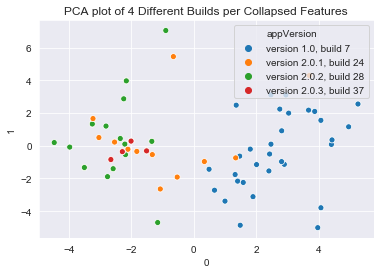

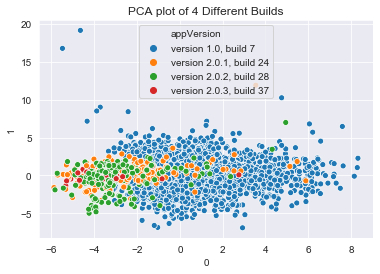

In [13]:
PCA_grouped_data, PCA_ungrouped_data = isolate_feature("appVersion", male_data)
sns.scatterplot(PCA_grouped_data[0], PCA_grouped_data[1], hue = PCA_grouped_data["appVersion"])
plt.grid()
plt.title("PCA plot of 4 Different Builds per Collapsed Features")
plt.show()

sns.scatterplot(PCA_ungrouped_data[0], PCA_ungrouped_data[1], hue = PCA_ungrouped_data["appVersion"])
plt.grid()
plt.title("PCA plot of 4 Different Builds")
plt.show()

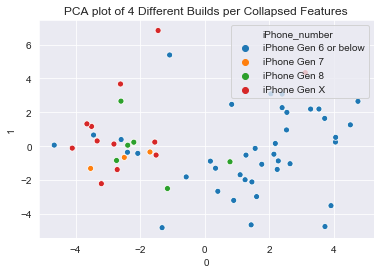

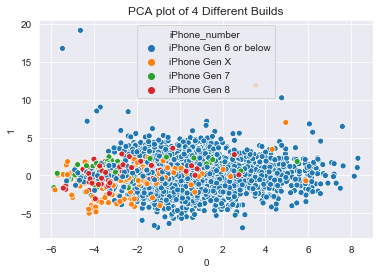

In [14]:
PCA_grouped_data, PCA_ungrouped_data = isolate_feature("iPhone_number", male_data)
sns.scatterplot(PCA_grouped_data[0], PCA_grouped_data[1], hue = PCA_grouped_data["iPhone_number"])
plt.grid()
plt.title("PCA plot of 4 Different Builds per Collapsed Features")
plt.show()

PCA_grouped_data, PCA_ungrouped_data = isolate_feature("iPhone_number", male_data)
sns.scatterplot(PCA_ungrouped_data[0], PCA_ungrouped_data[1], hue = PCA_ungrouped_data["iPhone_number"])
plt.grid()
plt.title("PCA plot of 4 Different Builds")
plt.show()

# Can our feature actually predict the phone info?

In [15]:
## imports ##
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn import svm, decomposition, tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn import metrics
from sklearn.model_selection import learning_curve, GridSearchCV, cross_val_score, validation_curve
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import warnings
from sklearn.feature_selection import RFECV, SelectKBest, chi2, SelectFromModel, RFE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
%matplotlib inline

warnings.simplefilter("ignore")
np.random.seed(100)

In [16]:
male_data[["x.no_of_steps", "y.no_of_steps", "z.no_of_steps", "AA.no_of_steps"]]
male_data["resultant_steps"] = np.sqrt(male_data["x.no_of_steps"]**2 + \
                                male_data["y.no_of_steps"]**2 + \
                                male_data["z.no_of_steps"]**2)

In [17]:
male_data = male_data[male_data["resultant_steps"] != 0]

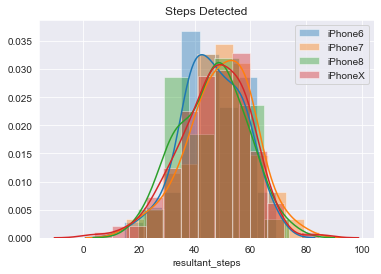

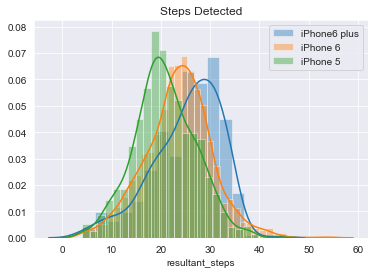

In [18]:
sns.distplot(male_data[(male_data["iPhone_number"] == "iPhone Gen 6 or below") &
                      (male_data["version"] == "V2")]["resultant_steps"], 
             label = "iPhone6")
sns.distplot(male_data[(male_data["iPhone_number"] == "iPhone Gen 7") &
                      (male_data["version"] == "V2")]["resultant_steps"], 
            label = "iPhone7")
sns.distplot(male_data[(male_data["iPhone_number"] == "iPhone Gen 8")&
                      (male_data["version"] == "V2")]["resultant_steps"],
            label = "iPhone8")
sns.distplot(male_data[(male_data["iPhone_number"] == "iPhone Gen X")&
                      (male_data["version"] == "V2")]["resultant_steps"],
            label = "iPhoneX")
plt.title("Steps Detected")
plt.legend()
plt.grid()
plt.show()


sns.distplot(male_data[(male_data["phoneInfo"] == "iPhone 6 Plus") &
                      (male_data["version"] == "V1")]["resultant_steps"], 
             label = "iPhone6 plus")
sns.distplot(male_data[(male_data["phoneInfo"] == "iPhone 6") &
                      (male_data["version"] == "V1")]["resultant_steps"], 
            label = "iPhone 6")
sns.distplot(male_data[(male_data["phoneInfo"] == "iPhone 5s (GSM)")&
                      (male_data["version"] == "V1")]["resultant_steps"],
            label = "iPhone 5")
plt.title("Steps Detected")
plt.legend()
plt.grid()
plt.show()

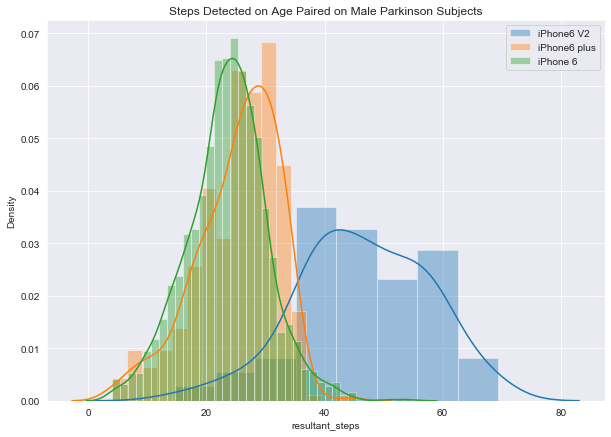

In [20]:

plt.figure(figsize = (10,7))
sns.distplot(male_data[(male_data["iPhone_number"] == "iPhone Gen 6 or below") &
                      (male_data["version"] == "V2")]["resultant_steps"], 
             label = "iPhone6 V2")


sns.distplot(male_data[(male_data["phoneInfo"] == "iPhone 6 Plus") &
                      (male_data["version"] == "V1")]["resultant_steps"], 
             label = "iPhone6 plus")
sns.distplot(male_data[(male_data["phoneInfo"] == "iPhone 6") &
                      (male_data["version"] == "V1")]["resultant_steps"], 
            label = "iPhone 6")
# sns.distplot(male_data[(male_data["phoneInfo"] == "iPhone 5s (GSM)")&
#                       (male_data["version"] == "V1")]["resultant_steps"],
#             label = "iPhone 5")
plt.title("Steps Detected on Age Paired on Male Parkinson Subjects")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

In [21]:
male_data

,AA.freeze_occurences,AA.frequency_of_peaks,AA.gait_step_regularity,AA.gait_stride_regularity,AA.gait_symmetry,AA.max_freeze_index,AA.no_of_steps,AA.speed_of_gait,PD,age,...,z.freeze_occurences,z.frequency_of_peaks,z.gait_step_regularity,z.gait_stride_regularity,z.gait_symmetry,z.max_freeze_index,z.no_of_steps,z.speed_of_gait,iPhone_number,resultant_steps
0,2.0,569.199744,0.923291,1.000000,0.076709,3.040462,10.0,0.207964,1.0,51.0,...,11.0,993.198951,0.387096,0.774384,0.387288,35.968739,21.0,0.165761,iPhone Gen 6 or below,33.734256
1,0.0,140.449073,0.905729,1.000000,0.094271,0.973890,9.0,0.288430,1.0,51.0,...,0.0,71.370086,0.401458,0.775038,0.373580,1.922677,20.0,0.217032,iPhone Gen 6 or below,34.073450
2,18.0,70.535398,0.930669,1.000000,0.069331,34.785969,9.0,0.244246,1.0,51.0,...,17.0,105.543686,0.394879,0.773926,0.379047,7.020706,20.0,0.177613,iPhone Gen 6 or below,32.939338
3,0.0,77.625979,0.919192,1.000000,0.080808,0.904931,9.0,0.244879,1.0,51.0,...,0.0,31436.673644,0.810743,0.810743,0.000000,1.724933,19.0,0.191470,iPhone Gen 6 or below,34.669872
4,0.0,152.521748,0.745541,0.904861,0.159320,0.799969,9.0,0.280797,1.0,51.0,...,2.0,99.343268,0.805861,0.805861,0.000000,8.038690,19.0,0.210117,iPhone Gen 6 or below,32.341923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2275,0.0,142.033888,0.740574,0.832038,0.091464,1.112260,14.0,0.274487,1.0,81.0,...,7.0,97.453835,0.919323,0.919323,0.000000,8.870247,28.0,0.341107,iPhone Gen 8,57.445626
2276,0.0,557.757598,0.905474,1.000000,0.094526,1.102616,13.0,0.232708,1.0,81.0,...,2.0,272.038407,0.859898,1.000000,0.140102,2.528325,24.0,0.203609,iPhone Gen 8,48.764741
2289,0.0,114.195189,1.000000,1.000000,0.000000,1.412048,6.0,0.106338,1.0,50.0,...,10.0,211.018940,0.000000,0.000000,0.000000,3.476959,0.0,0.128601,iPhone Gen 6 or below,14.560220
2305,1.0,254.369289,0.868958,1.000000,0.131042,2.782753,9.0,0.199697,1.0,57.0,...,22.0,371.078177,0.910678,0.910678,0.000000,9.407201,25.0,0.229863,iPhone Gen 7,39.874804


In [340]:
X_train, X_test, y_train, y_test = train_test_split(male_data[feature_columns], 
                                                    male_data["version"], test_size = 0.2,
                                                   random_state = 100)

In [344]:
gb = GradientBoostingClassifier()
rf = RandomForestClassifier()

In [346]:
gb.fit(X_train, y_train)
rf.fit(X_train, y_train)
print("")

In [349]:
## results
print(classification_report(gb.predict(X_test), y_test))
print(confusion_matrix(gb.predict(X_test), y_test))

              precision    recall  f1-score   support

          V1       1.00      0.98      0.99       648
          V2       0.84      0.97      0.90        74

    accuracy                           0.98       722
   macro avg       0.92      0.98      0.94       722
weighted avg       0.98      0.98      0.98       722

[[634  14]
 [  2  72]]


In [348]:
## results
print(classification_report(rf.predict(X_test), y_test))
print(confusion_matrix(rf.predict(X_test), y_test))

              precision    recall  f1-score   support

          V1       1.00      0.96      0.98       660
          V2       0.70      0.97      0.81        62

    accuracy                           0.96       722
   macro avg       0.85      0.96      0.89       722
weighted avg       0.97      0.96      0.96       722

[[634  26]
 [  2  60]]
